In [41]:
import pandas as pd

# Load your dataset
df = pd.read_csv("Dataset_Cleaned.csv")  # use your actual filename
df.columns = df.columns.str.strip()  # clean column names
df.dropna(subset=["Location", "Amenities", "Price (LKR)", "Query"], inplace=True)

# Lowercase and clean key columns
df["Location"] = df["Location"].str.lower()
df["Amenities"] = df["Amenities"].str.lower()
df["Query"] = df["Query"].str.lower()


In [ ]:
def categorize_price(price):
    if price < 8000:
        return "cheap"
    elif price < 20000:
        return "affordable"
    else:
        return "expensive"

df["Price_Category"] = df["Price (LKR)"].apply(categorize_price)


In [43]:
df["Label_Location"] = df["Location"]
df["Label_Price"] = df["Price_Category"]
df["Label_Amenities"] = df["Amenities"]


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline

# TF-IDF Vectorizer for query
tfidf = TfidfVectorizer()

# LOCATION model
X = df["Query"]
y_location = df["Label_Location"]
location_model = Pipeline([("tfidf", tfidf), ("clf", LogisticRegression())])
location_model.fit(X, y_location)

# PRICE model
y_price = df["Label_Price"]
price_model = Pipeline([("tfidf", tfidf), ("clf", LogisticRegression())])
price_model.fit(X, y_price)

# AMENITIES model (multi-label)
mlb = MultiLabelBinarizer()
df["Amenities_List"] = df["Label_Amenities"].apply(lambda x: [a.strip() for a in x.split(",")])
y_amenities = mlb.fit_transform(df["Amenities_List"])

from sklearn.multiclass import OneVsRestClassifier
amenity_model = Pipeline([
    ("tfidf", tfidf),
    ("clf", OneVsRestClassifier(LogisticRegression()))
])
amenity_model.fit(X, y_amenities)


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(estimator=LogisticRegression()))])

In [45]:
def extract_filters_custom_model(query):
    query = query.lower()

    predicted_location = location_model.predict([query])[0]
    predicted_price = price_model.predict([query])[0]
    predicted_amenities = mlb.inverse_transform(amenity_model.predict([query]))[0]

    return {
        "location": predicted_location,
        "amenities": predicted_amenities,
        "price_category": predicted_price
    }

# Test
print(extract_filters_custom_model("I want a cheap room in Malabe with wifi and laundry"))


{'location': 'malabe', 'amenities': (), 'price_category': 'affordable'}


In [46]:
# def search_boarding_houses(query):
#     filters = extract_filters_custom_model(query)

#     results = df[
#         df["Location"].str.contains(filters["location"]) &
#         df["Price_Category"].str.contains(filters["price_category"])
#     ]

#     for amenity in filters["amenities"]:
#         results = results[results["Amenities"].str.contains(amenity)]

#     return results[["Boarding_House_ID", "Location", "Price (LKR)", "Amenities"]]

# # Try it
# query = "boarding house in Malabe with AC and laundry"
# matched_results = search_boarding_houses(query)
# print(matched_results)

# List of known locations from dataset

import numpy as np


known_locations = df["Location"].dropna().str.lower().unique().tolist()

# Step 1: Extract filters using ML model + override if location is in query
def extract_filters_custom_model(query, threshold=0.3):
    query = query.lower()

    # Check for any known location directly in the query
    detected_location = next((loc for loc in known_locations if loc in query), None)

    # Predict using trained models
    loc_model = location_model.predict([query])[0]
    price = price_model.predict([query])[0]
    probs = amenity_model.predict_proba([query])
    
    # Multi-label amenity prediction
    pred_amenities = [
        mlb.classes_[i] for i, p in enumerate(probs)
        if isinstance(p, (list, tuple, np.ndarray)) and p[0] >= threshold
    ]

    return {
        "location": detected_location or loc_model,
        "price_category": price,
        "amenities": pred_amenities
    }

# Step 2: Search boarding houses
def search_boarding_houses(query):
    filters = extract_filters_custom_model(query)

    # Filter by location and price
    results = df[
        df["Location"].fillna("").str.lower().str.contains(filters["location"].lower()) &
        df["Price_Category"].fillna("").str.lower().str.contains(filters["price_category"].lower())
    ]

    # Filter by amenities
    for amenity in filters["amenities"]:
        results = results[
            results["Amenities"].fillna("").str.lower().str.contains(amenity)
        ]

    # Return selected columns
    return results[["Boarding_House_ID", "Location", "Price (LKR)", "Amenities"]]

query = "boarding house in Malabe with AC and laundry"
matched_results = search_boarding_houses(query)
print(matched_results)

    Boarding_House_ID Location  Price (LKR)                       Amenities
183             BD184   malabe        17394                         balcony
190             BD191   malabe        10398                       hot water
195             BD196   malabe        12820  pet friendly, air conditioning


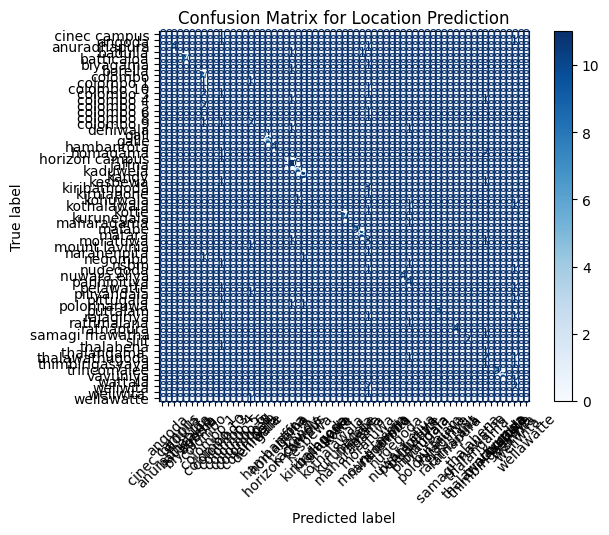

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict and compare with true values
y_true = df["Label_Location"]
y_pred = location_model.predict(df["Query"])

cm = confusion_matrix(y_true, y_pred, labels=location_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=location_model.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix for Location Prediction")
plt.show()


C:\Users\kavin\AppData\Local\Temp\ipykernel_7108\2774830354.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette="coolwarm")


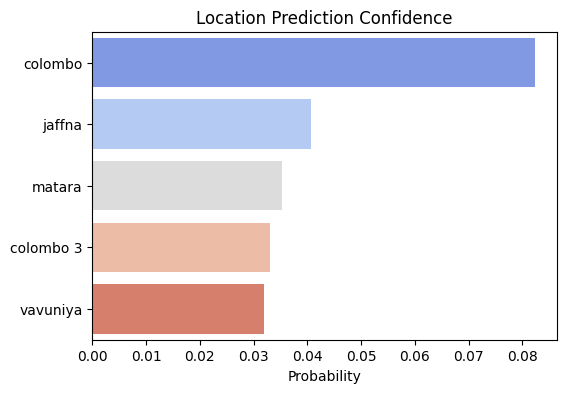

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_prediction_confidence(query):
    probs = location_model.predict_proba([query])[0]
    top_n = sorted(zip(location_model.classes_, probs), key=lambda x: x[1], reverse=True)[:5]

    labels, scores = zip(*top_n)
    plt.figure(figsize=(6,4))
    sns.barplot(x=scores, y=labels, palette="coolwarm")
    plt.title("Location Prediction Confidence")
    plt.xlabel("Probability")
    plt.show()

# Try it
get_prediction_confidence("cheap boarding near colombo with wifi and laundry")


In [24]:
import speech_recognition as sr

def get_voice_query():
    recognizer = sr.Recognizer()
    with sr.Microphone() as source:
        print("🎤 Speak now...")
        audio = recognizer.listen(source)

        try:
            text = recognizer.recognize_google(audio)
            print("You said:", text)
            return text
        except sr.UnknownValueError:
            print("Sorry, I couldn’t understand.")
            return ""
        except sr.RequestError:
            print("API unavailable.")
            return ""

# Example usage
query = get_voice_query()
if query:
    results = search_boarding_houses(query)
    print(results)


🎤 Speak now...
Sorry, I couldn’t understand.


In [49]:
from sklearn.metrics import accuracy_score

# True labels
y_true_location = df["Label_Location"]

# Predicted labels
y_pred_location = location_model.predict(df["Query"])

# Accuracy
location_accuracy = accuracy_score(y_true_location, y_pred_location)
print(f"Location Prediction Accuracy: {location_accuracy:.2f}")


Location Prediction Accuracy: 0.60


In [50]:
# True labels
y_true_price = df["Label_Price"]

# Predicted labels
y_pred_price = price_model.predict(df["Query"])

# Accuracy
price_accuracy = accuracy_score(y_true_price, y_pred_price)
print(f"Price Category Prediction Accuracy: {price_accuracy:.2f}")


Price Category Prediction Accuracy: 0.74


In [51]:
from sklearn.metrics import accuracy_score, f1_score

# True labels (binary)
y_true_amenities = mlb.transform(df["Amenities_List"])

# Predicted labels (binary)
y_pred_amenities = amenity_model.predict(df["Query"])

# Subset accuracy (exact match)
amenity_accuracy = accuracy_score(y_true_amenities, y_pred_amenities)
print(f"Amenities Prediction Accuracy (Exact Match): {amenity_accuracy:.2f}")

# F1 Score (more forgiving)
f1 = f1_score(y_true_amenities, y_pred_amenities, average='micro')
print(f"Amenities Prediction F1 Score (micro): {f1:.2f}")


Amenities Prediction Accuracy (Exact Match): 0.20
Amenities Prediction F1 Score (micro): 0.40


In [52]:
print("🎯 Model Evaluation Summary")
print(f"📍 Location Accuracy     : {location_accuracy:.2%}")
print(f"💰 Price Category Accuracy: {price_accuracy:.2%}")
print(f"🏷️ Amenities Exact Match : {amenity_accuracy:.2%}")
print(f"🏷️ Amenities F1 Score    : {f1:.2%}")


🎯 Model Evaluation Summary
📍 Location Accuracy     : 60.32%
💰 Price Category Accuracy: 74.07%
🏷️ Amenities Exact Match : 20.11%
🏷️ Amenities F1 Score    : 40.15%


In [53]:
import joblib

# Save location model
joblib.dump(location_model, 'location_model.pkl')

# Save price model
joblib.dump(price_model, 'price_model.pkl')

# Save amenities model
joblib.dump(amenity_model, 'amenity_model.pkl')

# Save MultiLabelBinarizer (for amenities)
joblib.dump(mlb, 'mlb.pkl')


['mlb.pkl']

In [54]:
import joblib

location_model = joblib.load('location_model.pkl')
price_model = joblib.load('price_model.pkl')
amenity_model = joblib.load('amenity_model.pkl')
mlb = joblib.load('mlb.pkl')


In [56]:
query = "cheap room in malabe with kitchen"
filters = extract_filters_custom_model(query)  # using loaded models

print(filters)


{'location': 'malabe', 'price_category': 'affordable', 'amenities': []}


In [57]:
print("Amenities classes:", mlb.classes_)


Amenities classes: ['' 'ac' 'air condition' 'air conditioning' 'attach bathroom'
 'attach bathroom and laundry.' 'attach bathroom.' 'balcony' 'breakfast'
 'garden' 'gym' 'hot water' 'kitchen' 'laundary' 'laundry' 'parking'
 'pet friendly' 'pet-friendly' 'pool' 'security' 'study/workspace' 'tv'
 'wi-fi' 'wifi']


In [58]:
query = query.lower()


In [59]:
probs = amenity_model.predict_proba([query])[0]
threshold = 0.3  # you can tune this

predicted_amenities = [mlb.classes_[i] for i, p in enumerate(probs) if p > threshold]
print("Predicted amenities:", predicted_amenities)


Predicted amenities: ['kitchen']


In [60]:
def predict_amenities_with_threshold(query, threshold=0.3):
    # Make sure to preprocess query same as training (lowercase)
    query = query.lower()
    probs = amenity_model.predict_proba([query])[0]
    predicted_amenities = [mlb.classes_[i] for i, p in enumerate(probs) if p >= threshold]
    return predicted_amenities

query = "Boarding house in colombo with wifi and laundry"
amenities_pred = predict_amenities_with_threshold(query)
print("Predicted amenities:", amenities_pred)


Predicted amenities: ['laundry', 'wifi']


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.pipeline import Pipeline

# # ------------- Step 1: Load and preprocess your dataset ------------------
# # Assuming your dataframe 'df' is loaded with columns: Query, Location, Price (LKR), Amenities, Boarding_House_ID

# # Categorize price into buckets
# def categorize_price(price):
#     if price < 10000:
#         return 'cheap'
#     elif price < 20000:
#         return 'affordable'
#     else:
#         return 'expensive'

# df['Price_Category'] = df['Price (LKR)'].apply(categorize_price)

# # Convert Amenities column into list of amenities
# df['Amenities_List'] = df['Amenities'].apply(lambda x: [amen.strip().lower() for amen in x.split(',')])

# # ----------------- Step 2: Prepare labels -------------------------------

# y_location = df['Location'].str.lower()
# y_price = df['Price_Category']
# mlb = MultiLabelBinarizer()
# y_amenities = mlb.fit_transform(df['Amenities_List'])

# X = df['Query'].str.lower()  # Using Query text as input

# # ----------------- Step 3: Train Models -------------------------------

# # Location Model
# location_model = Pipeline([
#     ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
#     ('clf', LogisticRegression(max_iter=500))
# ])
# location_model.fit(X, y_location)

# # Price Model
# price_model = Pipeline([
#     ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
#     ('clf', LogisticRegression(max_iter=500))
# ])
# price_model.fit(X, y_price)

# # Amenities Multi-label Model
# amenity_model = Pipeline([
#     ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
#     ('clf', MultiOutputClassifier(LogisticRegression(max_iter=500)))
# ])
# amenity_model.fit(X, y_amenities)

# # ----------------- Step 4: Define query filter extraction ----------------

# def extract_filters_custom_model(query, threshold=0.3):
#     query = query.lower()
#     pred_location = location_model.predict([query])[0]
#     pred_price = price_model.predict([query])[0]
#     pred_amenities_prob = amenity_model.predict_proba([query])
    
#     # Multi-label probability thresholding
#     pred_amenities = []
#     for idx, probs in enumerate(pred_amenities_prob):
#         if probs[0][1] >= threshold:
#             pred_amenities.append(mlb.classes_[idx])
    
#     return {
#         'location': pred_location,
#         'price_category': pred_price,
#         'amenities': pred_amenities
#     }

# # ----------------- Step 5: Search function ------------------------------

# def search_boarding_houses(query):
#     filters = extract_filters_custom_model(query)
    
#     print("Filters extracted:", filters)

#     # Filter dataframe based on predicted filters
#     results = df[
#         df['Location'].str.lower().str.contains(filters['location'])
#         & df['Price_Category'].str.contains(filters['price_category'])
#     ]

#     for amen in filters['amenities']:
#         results = results[results['Amenities'].str.lower().str.contains(amen)]

#     # Show top 5 results
#     top_results = results.head(5)[['Boarding_House_ID', 'Location', 'Price (LKR)', 'Amenities']]
#     print("\nTop matching boarding houses:")
#     for i, row in top_results.iterrows():
#         print(f"{i+1}. {row['Boarding_House_ID']} - {row['Location']} | Price: {row['Price (LKR)']} | Amenities: {row['Amenities']}")

# # ----------------- Step 6: Test your search -----------------------------

# search_boarding_houses("Looking for an affordable boarding house in Malabe with parking")


Filters extracted: {'location': 'malabe', 'price_category': 'affordable', 'amenities': ['parking']}

Top matching boarding houses:


In [61]:
import joblib

# Save models
joblib.dump(location_model, 'location_model.pkl')
joblib.dump(price_model, 'price_model.pkl')
joblib.dump(amenity_model, 'amenity_model.pkl')

# Save MultiLabelBinarizer (for amenities)
joblib.dump(mlb, 'mlb.pkl')


['mlb.pkl']

In [62]:
from sklearn.metrics import accuracy_score, f1_score

# 1. Location Accuracy
y_true_location = df["Label_Location"]
y_pred_location = location_model.predict(df["Query"])
location_accuracy = accuracy_score(y_true_location, y_pred_location)

# 2. Price Category Accuracy
y_true_price = df["Label_Price"]
y_pred_price = price_model.predict(df["Query"])
price_accuracy = accuracy_score(y_true_price, y_pred_price)

# 3. Amenities Prediction Accuracy and F1 Score
y_true_amenities = mlb.transform(df["Amenities_List"])
y_pred_amenities = amenity_model.predict(df["Query"])

# Exact match accuracy (all labels must match)
amenity_accuracy = accuracy_score(y_true_amenities, y_pred_amenities)

# Micro-average F1 score (better for multi-label)
f1 = f1_score(y_true_amenities, y_pred_amenities, average='micro')

# Print Summary
print("🎯 Model Evaluation Summary")
print(f"📍 Location Accuracy     : {location_accuracy:.2%}")
print(f"💰 Price Category Accuracy: {price_accuracy:.2%}")
print(f"🏷️ Amenities Exact Match : {amenity_accuracy:.2%}")
print(f"🏷️ Amenities F1 Score    : {f1:.2%}")


🎯 Model Evaluation Summary
📍 Location Accuracy     : 60.32%
💰 Price Category Accuracy: 74.07%
🏷️ Amenities Exact Match : 20.11%
🏷️ Amenities F1 Score    : 40.15%
